In [87]:
import numpy as np
import pandas as pd
import pulp
import itertools
import gmaps
import googlemaps
import matplotlib.pyplot as plt

In [88]:
API_KEY = 'api_key'
gmaps.configure(api_key=API_KEY)
googlemaps = googlemaps.Client(key=API_KEY)

3 araç ile mevcut sevkiyatın Toplam Yolu: 281 km
Araç Sayısı: 2
CVRP - 2 araç ile Toplam Yol: 221.63 km
Mevcut sisteme göre toplam yol farkı: 59.37 km


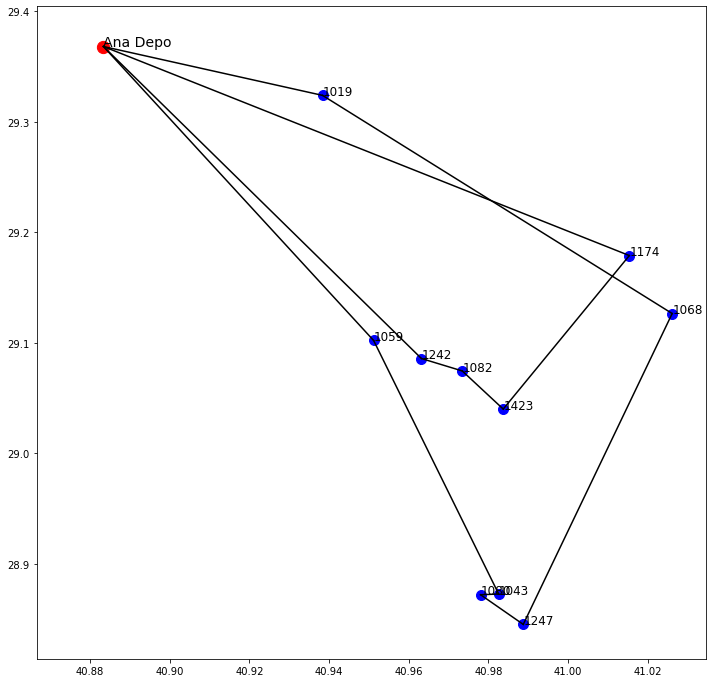

In [93]:
# customer count ('0' is depot) 
customer_count = 11

# the number of vehicle
vehicle_count = 2

# the capacity of vehicle
vehicle_capacity = 250

# fix random seed
np.random.seed(seed=777)

# set depot latitude and longitude
depot_latitude = 40.883345
depot_longitude = 29.368103

# csv dosyalarından ilgili mağazaların lati,long değerlerini çekme ve ekrandaki noktalar için mağaza kodu okuma kısmı
df=pd.read_csv('cvrp_koor.csv', sep=";")

magaza=pd.read_csv('cvrp_magaza.csv', sep=";")

# ilk adrese deponın lati ve long veriliyor ('0' = Ana Depo)
df.iloc[:0].latitude = depot_latitude
df.iloc[:0].longitude = depot_longitude
df.iloc[:0].demand = 0


# Google API ile uzaklık matrisi hesaplama
def _distance_calculator(_df):
    
    _distance_result = np.zeros((len(_df),len(_df)))
    _df['latitude-longitude'] = '0'
    for i in range(len(_df)):
        _df['latitude-longitude'].iloc[i] = str(_df.latitude[i]) + ',' + str(_df.longitude[i])
    
    for i in range(len(_df)):
        for j in range(len(_df)):
            
            # calculate distance of all pairs
            _google_maps_api_result = googlemaps.directions(_df['latitude-longitude'].iloc[i],
                                                            _df['latitude-longitude'].iloc[j],
                                                            mode = 'driving')
            # append distance to result list
            _distance_result[i][j] = _google_maps_api_result[0]['legs'][0]['distance']['value']
    
    return _distance_result

distance = _distance_calculator(df)
plot_result = _plot_on_gmaps(df)
plot_result


# solve with pulp
for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective9 function
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(customer_count) 
                          for i in range (customer_count))

    # constraints
    # foluma (2)
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(customer_count) 
                              for k in range(vehicle_count)) == 1 

    # foluma (3)
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # foluma (4)
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #foluma (5)
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 


    # fomula (6)
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    
#Sonuç gösterme kısmı
    if problem.solve() == 1:
        print('3 araç ile mevcut sevkiyatın Toplam Yolu: 281 km')
        print('Araç Sayısı:', vehicle_count)
        b=pulp.value(problem.objective)/1000;
        print('CVRP - 2 araç ile Toplam Yol: {0:.2f}'.format(b),'km')
        a=(281-pulp.value(problem.objective)/1000);
        print('Mevcut sisteme göre toplam yol farkı: {0:.2f}'.format(a),'km')
        break
        

# visualization : plotting with matplolib
plt.figure(figsize=(12,12))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='red', s=150)
        plt.text(df.latitude[i], df.longitude[i], "Ana Depo", fontsize=14)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='blue', s=100)
        plt.text(df.latitude[i], df.longitude[i], str(magaza.magaza[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()
